In [16]:

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms, models
from torchvision.models import VGG19_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import time
from tqdm import tqdm
import glob

In [17]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [18]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing cross entropy loss."""

    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss


In [19]:
class BreakHisDataset(Dataset):
    """BreakHis dataset class for tumor classification."""

    def __init__(self, image_paths: List[str], labels: List[int],
                 transform: Optional[transforms.Compose] = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
class TumorClassifier(nn.Module):
    """VGG19-based tumor classifier."""

    def __init__(self, num_classes: int = 2, dropout_rate: float = 0.5):
        super().__init__()

        # Load pretrained VGG19
        self.backbone = models.vgg19(weights=VGG19_Weights.DEFAULT)

        # Remove the classifier
        self.features = self.backbone.features
        self.avgpool = self.backbone.avgpool

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )

        # Initialize classifier weights
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights."""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def freeze_backbone(self):
        """Freeze backbone parameters."""
        for param in self.features.parameters():
            param.requires_grad = False

    def unfreeze_last_conv_layers(self, num_layers: int = 4):
        """Unfreeze last few convolutional layers."""
        # Unfreeze last num_layers conv layers
        conv_layers = [m for m in self.features.modules() if isinstance(m, nn.Conv2d)]
        for layer in conv_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

In [21]:
class EarlyStopping:
    """Early stopping utility."""

    def __init__(self, patience: int = 10, min_delta: float = 0.001,
                 mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score: float):
        if self.best_score is None:
            self.best_score = val_score
        elif self.mode == 'min':
            if val_score < self.best_score - self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        else:  # mode == 'max'
            if val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [22]:

class MetricsCalculator:
    """Utility class for calculating classification metrics."""

    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray,
                         y_pred_proba: np.ndarray) -> Dict[str, float]:
        """Calculate all classification metrics."""

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1 = f1_score(y_true, y_pred, average='binary')
        auc_roc = roc_auc_score(y_true, y_pred_proba)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        }

    @staticmethod
    def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix"):
        """Plot confusion matrix heatmap."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Benign', 'Malignant'],
                   yticklabels=['Benign', 'Malignant'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()


In [23]:
class BreakHisTrainer:
    """Main trainer class for BreakHis dataset."""

    def __init__(self, data_dir: str, batch_size: int = 32,
                 num_workers: int = 4, device: str = 'cuda'):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Results storage
        self.results = {}

        # Data transforms
        self.train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def parse_dataset(self) -> Dict[str, List]:
        """Parse BreakHis dataset structure using glob pattern matching."""
        print("Parsing BreakHis dataset...")

        # Try different possible paths for the dataset
        possible_paths = [
            os.path.join(self.data_dir, 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, '**/*.png'),
        ]

        breast_img_paths = []
        for pattern in possible_paths:
            breast_img_paths = glob.glob(pattern, recursive=True)
            if breast_img_paths:
                print(f"Found images using pattern: {pattern}")
                break

        if not breast_img_paths:
            raise FileNotFoundError(f"No PNG files found in {self.data_dir}. Please check the dataset path.")

        print(f"Found {len(breast_img_paths)} image files")

        data_info = {
            'image_paths': [],
            'labels': [],
            'magnifications': [],
            'patient_ids': []
        }

        for img_path in breast_img_paths:
            try:
                # Extract information from path
                path_parts = img_path.split(os.sep)

                # Find benign/malignant classification from path
                if 'benign' in img_path.lower():
                    label = 0  # benign
                elif 'malignant' in img_path.lower():
                    label = 1  # malignant
                else:
                    continue

                # Extract filename for further processing
                filename = os.path.basename(img_path)

                # Extract magnification from filename (format: SOB_B_A-14-22549AB-40-001.png)
                if '-40-' in filename:
                    mag = '40X'
                elif '-100-' in filename:
                    mag = '100X'
                elif '-200-' in filename:
                    mag = '200X'
                elif '-400-' in filename:
                    mag = '400X'
                else:
                    continue

                # Extract patient ID from filename (format: SOB_B_A-14-22549AB-40-001.png)
                # Patient ID is the part before the magnification
                parts = filename.split('-')
                if len(parts) >= 3:
                    patient_id = '-'.join(parts[:3])  # SOB_B_A-14-22549AB
                else:
                    patient_id = filename.split('.')[0]

                data_info['image_paths'].append(img_path)
                data_info['labels'].append(label)
                data_info['magnifications'].append(mag)
                data_info['patient_ids'].append(patient_id)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        print(f"Successfully parsed {len(data_info['image_paths'])} images")
        print(f"Benign: {len([l for l in data_info['labels'] if l == 0])}")
        print(f"Malignant: {len([l for l in data_info['labels'] if l == 1])}")
        print(f"Magnifications: {set(data_info['magnifications'])}")
        print(f"Unique patients: {len(set(data_info['patient_ids']))}")

        return data_info

    def create_patient_splits(self, data_info: Dict, test_size: float = 0.2,
                            val_size: float = 0.2) -> Dict[str, Dict]:
        """Create patient-level train/val/test splits."""

        # Get unique patients with their labels
        df = pd.DataFrame(data_info)
        patient_labels = df.groupby('patient_ids')['labels'].first().reset_index()

        # First split: train+val vs test
        train_val_patients, test_patients = train_test_split(
            patient_labels['patient_ids'].tolist(),
            test_size=test_size,
            stratify=patient_labels['labels'].tolist(),
            random_state=42
        )

        # Second split: train vs val
        train_val_labels = patient_labels[patient_labels['patient_ids'].isin(train_val_patients)]['labels'].tolist()
        train_patients, val_patients = train_test_split(
            train_val_patients,
            test_size=val_size / (1 - test_size),
            stratify=train_val_labels,
            random_state=42
        )

        # Create splits for each magnification
        magnifications = ['40X', '100X', '200X', '400X', 'All']
        splits = {}

        for mag in magnifications:
            if mag == 'All':
                mag_mask = pd.Series([True] * len(df))
            else:
                mag_mask = df['magnifications'] == mag

            mag_df = df[mag_mask]

            train_mask = mag_df['patient_ids'].isin(train_patients)
            val_mask = mag_df['patient_ids'].isin(val_patients)
            test_mask = mag_df['patient_ids'].isin(test_patients)

            splits[mag] = {
                'train': {
                    'image_paths': mag_df[train_mask]['image_paths'].tolist(),
                    'labels': mag_df[train_mask]['labels'].tolist()
                },
                'val': {
                    'image_paths': mag_df[val_mask]['image_paths'].tolist(),
                    'labels': mag_df[val_mask]['labels'].tolist()
                },
                'test': {
                    'image_paths': mag_df[test_mask]['image_paths'].tolist(),
                    'labels': mag_df[test_mask]['labels'].tolist()
                }
            }

            print(f"\n{mag} - Train: {len(splits[mag]['train']['labels'])}, "
                  f"Val: {len(splits[mag]['val']['labels'])}, "
                  f"Test: {len(splits[mag]['test']['labels'])}")

        return splits

    def create_data_loaders(self, splits: Dict, magnification: str) -> Dict[str, DataLoader]:
        """Create data loaders for a specific magnification."""

        split_data = splits[magnification]

        # Create datasets
        train_dataset = BreakHisDataset(
            split_data['train']['image_paths'],
            split_data['train']['labels'],
            self.train_transforms
        )

        val_dataset = BreakHisDataset(
            split_data['val']['image_paths'],
            split_data['val']['labels'],
            self.val_transforms
        )

        test_dataset = BreakHisDataset(
            split_data['test']['image_paths'],
            split_data['test']['labels'],
            self.val_transforms
        )

        # Handle class imbalance with weighted sampling
        train_labels = split_data['train']['labels']
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(train_labels),
            y=train_labels
        )

        sample_weights = [class_weights[label] for label in train_labels]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            sampler=sampler,
            num_workers=self.num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        return {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }

    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   criterion: nn.Module, optimizer: torch.optim.Optimizer) -> float:
        """Train for one epoch."""
        model.train()
        total_loss = 0.0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def validate_epoch(self, model: nn.Module, val_loader: DataLoader,
                      criterion: nn.Module) -> Tuple[float, float]:
        """Validate for one epoch."""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of malignant

        avg_loss = total_loss / len(val_loader)
        auc_roc = roc_auc_score(all_labels, all_probs)

        return avg_loss, auc_roc

    def test_model(self, model: nn.Module, test_loader: DataLoader) -> Dict[str, float]:
        """Test the model and return metrics."""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())

        return MetricsCalculator.calculate_metrics(
            np.array(all_labels),
            np.array(all_preds),
            np.array(all_probs)
        )

    def train_magnification(self, splits: Dict, magnification: str,
                          epochs: int = 100) -> Dict[str, float]:
        """Train model for a specific magnification."""

        print(f"\n{'='*60}")
        print(f"Training on {magnification} magnification")
        print(f"{'='*60}")

        # Create data loaders
        data_loaders = self.create_data_loaders(splits, magnification)

        # Initialize model
        model = TumorClassifier(num_classes=2, dropout_rate=0.5)
        model.to(self.device)

        # Loss function
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

        # Phase 1: Train classifier head with frozen backbone
        print("\nPhase 1: Training classifier head (frozen backbone)")
        model.freeze_backbone()

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        best_auc = 0.0
        best_model_state = None

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model from Phase 1
        model.load_state_dict(best_model_state)

        # Phase 2: Fine-tune with unfrozen last conv layers
        print("\nPhase 2: Fine-tuning with unfrozen last conv layers")
        model.unfreeze_last_conv_layers(num_layers=4)

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model and test
        model.load_state_dict(best_model_state)
        test_metrics = self.test_model(model, data_loaders['test'])

        print(f"\nBest validation AUC: {best_auc:.4f}")
        print(f"Test metrics:")
        for metric, value in test_metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric}: {value:.4f}")

        # Plot confusion matrix
        cm = test_metrics['confusion_matrix']
        MetricsCalculator.plot_confusion_matrix(cm, f"Confusion Matrix - {magnification}")

        return test_metrics

    def run_all_experiments(self, data_dir: str) -> pd.DataFrame:
        """Run experiments for all magnifications."""

        print("Starting BreakHis tumor classification experiments...")

        # Parse dataset
        data_info = self.parse_dataset()

        # Create patient-level splits
        splits = self.create_patient_splits(data_info)

        # Run experiments for each magnification
        magnifications = ['40X', '100X', '200X', '400X', 'All']
        results = []

        for mag in magnifications:
            print(f"\nStarting experiment for {mag}...")
            metrics = self.train_magnification(splits, mag)

            result = {
                'Magnification': mag,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'Specificity': metrics['specificity'],
                'F1': metrics['f1'],
                'AUC-ROC': metrics['auc_roc']
            }
            results.append(result)

            # Store confusion matrix separately
            self.results[mag] = {
                'metrics': result,
                'confusion_matrix': metrics['confusion_matrix']
            }

        # Create results DataFrame
        results_df = pd.DataFrame(results)

        # Display results table
        print("\n" + "="*80)
        print("FINAL RESULTS TABLE")
        print("="*80)
        print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

        return results_df

In [24]:
def main():
    """Main function to run the experiments."""

    # Download dataset using kagglehub
    import kagglehub

    # Download dataset
    path = kagglehub.dataset_download("ambarish/breakhis")
    print("Path to dataset files:", path)

    # Configuration
    DATA_DIR = path  # Use the downloaded path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")

    # Initialize trainer
    trainer = BreakHisTrainer(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Run all experiments
    results_df = trainer.run_all_experiments(DATA_DIR)

    # Save results
    results_df.to_csv('breakhis_results.csv', index=False)
    print("\nResults saved to 'breakhis_results.csv'")

    # Display final summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY")
    print("="*80)
    print(f"Average Accuracy: {results_df['Accuracy'].mean():.4f}")
    print(f"Average AUC-ROC: {results_df['AUC-ROC'].mean():.4f}")
    print(f"Best performing magnification: {results_df.loc[results_df['Accuracy'].idxmax(), 'Magnification']}")

    return results_df

Path to dataset files: /kaggle/input/breakhis
Using device: cuda
Starting BreakHis tumor classification experiments...
Parsing BreakHis dataset...
Found images using pattern: /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png
Found 7909 image files
Successfully parsed 7909 images
Benign: 2480
Malignant: 5429
Magnifications: {'200X', '100X', '400X', '40X'}
Unique patients: 82

40X - Train: 1172, Val: 382, Test: 441

100X - Train: 1201, Val: 403, Test: 477

200X - Train: 1188, Val: 382, Test: 443

400X - Train: 1059, Val: 367, Test: 394

All - Train: 4620, Val: 1534, Test: 1755

Starting experiment for 40X...

Training on 40X magnification


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.7MB/s]



Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Epoch   1: Train Loss: 2.7136, Val Loss: 0.6922, Val AUC: 0.7829


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch   2: Train Loss: 0.6031, Val Loss: 0.6121, Val AUC: 0.7154


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   3: Train Loss: 0.5640, Val Loss: 0.6896, Val AUC: 0.7360


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch   4: Train Loss: 0.5348, Val Loss: 0.6005, Val AUC: 0.7256


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch   5: Train Loss: 0.5445, Val Loss: 0.6109, Val AUC: 0.7462


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch   6: Train Loss: 0.5335, Val Loss: 0.6536, Val AUC: 0.7029


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   7: Train Loss: 0.5204, Val Loss: 0.6362, Val AUC: 0.6963


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch   8: Train Loss: 0.5210, Val Loss: 0.5834, Val AUC: 0.7485


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch   9: Train Loss: 0.5209, Val Loss: 0.6046, Val AUC: 0.7413


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  10: Train Loss: 0.4909, Val Loss: 0.6060, Val AUC: 0.7537


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch  11: Train Loss: 0.5001, Val Loss: 0.6363, Val AUC: 0.7588
Early stopping at epoch 11

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch   1: Train Loss: 0.4829, Val Loss: 0.5783, Val AUC: 0.8172


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Epoch   2: Train Loss: 0.4561, Val Loss: 0.5932, Val AUC: 0.8333


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch   3: Train Loss: 0.4331, Val Loss: 0.5216, Val AUC: 0.8438


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch   4: Train Loss: 0.4109, Val Loss: 0.5620, Val AUC: 0.8529


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch   5: Train Loss: 0.3985, Val Loss: 0.6295, Val AUC: 0.8410


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch   6: Train Loss: 0.4041, Val Loss: 0.6319, Val AUC: 0.8078


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch   7: Train Loss: 0.3944, Val Loss: 0.5754, Val AUC: 0.8405


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   8: Train Loss: 0.3871, Val Loss: 0.5178, Val AUC: 0.8373


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch   9: Train Loss: 0.3711, Val Loss: 0.6287, Val AUC: 0.7880


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch  10: Train Loss: 0.3652, Val Loss: 0.5423, Val AUC: 0.7960


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch  11: Train Loss: 0.3621, Val Loss: 0.5498, Val AUC: 0.7674


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch  12: Train Loss: 0.3541, Val Loss: 0.5678, Val AUC: 0.7924


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  13: Train Loss: 0.3525, Val Loss: 0.6150, Val AUC: 0.7632


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  14: Train Loss: 0.3532, Val Loss: 0.6256, Val AUC: 0.7885
Early stopping at epoch 14


Testing: 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]



Best validation AUC: 0.8529
Test metrics:
  accuracy: 0.8526
  precision: 0.9254
  recall: 0.8147
  specificity: 0.9066
  f1: 0.8665
  auc_roc: 0.8737


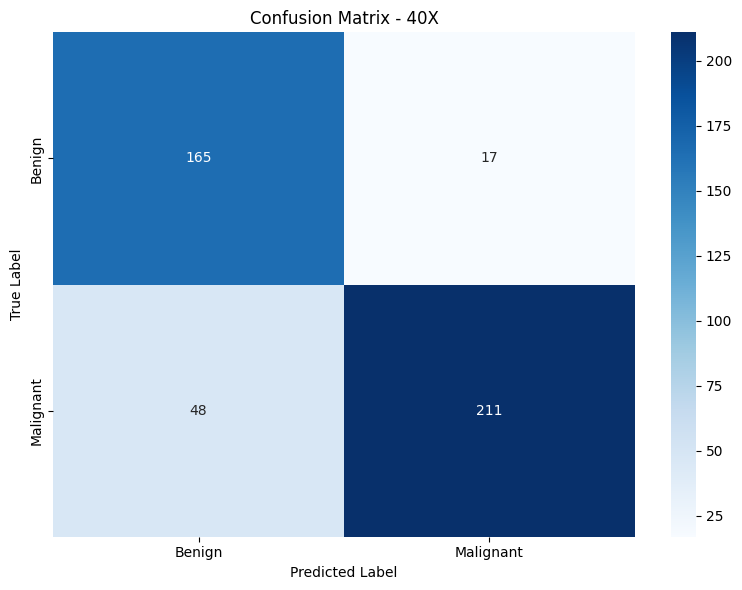


Starting experiment for 100X...

Training on 100X magnification

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch   1: Train Loss: 2.6935, Val Loss: 0.5792, Val AUC: 0.7566


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch   2: Train Loss: 0.6069, Val Loss: 0.6056, Val AUC: 0.7870


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch   3: Train Loss: 0.5753, Val Loss: 0.6219, Val AUC: 0.7824


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch   4: Train Loss: 0.5451, Val Loss: 0.6195, Val AUC: 0.8022


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch   5: Train Loss: 0.5499, Val Loss: 0.5529, Val AUC: 0.8091


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch   6: Train Loss: 0.5430, Val Loss: 0.5694, Val AUC: 0.8147


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch   7: Train Loss: 0.5521, Val Loss: 0.5546, Val AUC: 0.8098


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch   8: Train Loss: 0.5478, Val Loss: 0.6131, Val AUC: 0.8055


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch   9: Train Loss: 0.5257, Val Loss: 0.5658, Val AUC: 0.8041


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch  10: Train Loss: 0.5196, Val Loss: 0.5672, Val AUC: 0.8268


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch  11: Train Loss: 0.5353, Val Loss: 0.5673, Val AUC: 0.8098


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch  12: Train Loss: 0.5375, Val Loss: 0.6196, Val AUC: 0.8364


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch  13: Train Loss: 0.5280, Val Loss: 0.7071, Val AUC: 0.8390


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch  14: Train Loss: 0.5375, Val Loss: 0.5660, Val AUC: 0.8311


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch  15: Train Loss: 0.5203, Val Loss: 0.5664, Val AUC: 0.8339


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch  16: Train Loss: 0.5277, Val Loss: 0.5565, Val AUC: 0.8258


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch  17: Train Loss: 0.5072, Val Loss: 0.6448, Val AUC: 0.8249


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch  18: Train Loss: 0.5206, Val Loss: 0.5440, Val AUC: 0.8100


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch  19: Train Loss: 0.5134, Val Loss: 0.5760, Val AUC: 0.8363


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch  20: Train Loss: 0.4848, Val Loss: 0.5653, Val AUC: 0.8426


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch  21: Train Loss: 0.4963, Val Loss: 0.5788, Val AUC: 0.8329


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


Epoch  22: Train Loss: 0.4777, Val Loss: 0.5981, Val AUC: 0.8334


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch  23: Train Loss: 0.4808, Val Loss: 0.5519, Val AUC: 0.8354


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch  24: Train Loss: 0.4841, Val Loss: 0.5709, Val AUC: 0.8228


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch  25: Train Loss: 0.4806, Val Loss: 0.5443, Val AUC: 0.8216


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch  26: Train Loss: 0.4760, Val Loss: 0.5745, Val AUC: 0.8276


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch  27: Train Loss: 0.4662, Val Loss: 0.5714, Val AUC: 0.8307


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch  28: Train Loss: 0.4481, Val Loss: 0.5949, Val AUC: 0.8305


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch  29: Train Loss: 0.4612, Val Loss: 0.5913, Val AUC: 0.8335


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch  30: Train Loss: 0.4529, Val Loss: 0.5741, Val AUC: 0.8331
Early stopping at epoch 30

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch   1: Train Loss: 0.5503, Val Loss: 0.5913, Val AUC: 0.8225


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch   2: Train Loss: 0.4431, Val Loss: 0.5574, Val AUC: 0.8643


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch   3: Train Loss: 0.4406, Val Loss: 0.5838, Val AUC: 0.8412


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch   4: Train Loss: 0.4330, Val Loss: 0.6482, Val AUC: 0.8611


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


Epoch   5: Train Loss: 0.4191, Val Loss: 0.5396, Val AUC: 0.8694


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch   6: Train Loss: 0.4032, Val Loss: 0.5267, Val AUC: 0.8372


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Epoch   7: Train Loss: 0.3992, Val Loss: 0.5310, Val AUC: 0.8205


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch   8: Train Loss: 0.4031, Val Loss: 0.5815, Val AUC: 0.8456


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch   9: Train Loss: 0.3722, Val Loss: 0.5276, Val AUC: 0.8880


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch  10: Train Loss: 0.3837, Val Loss: 0.5301, Val AUC: 0.8844


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch  11: Train Loss: 0.3733, Val Loss: 0.5369, Val AUC: 0.8665


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch  12: Train Loss: 0.3895, Val Loss: 0.5295, Val AUC: 0.8657


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch  13: Train Loss: 0.3680, Val Loss: 0.5708, Val AUC: 0.8502


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch  14: Train Loss: 0.3728, Val Loss: 0.4940, Val AUC: 0.8683


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch  15: Train Loss: 0.3869, Val Loss: 0.5722, Val AUC: 0.8566


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch  16: Train Loss: 0.3681, Val Loss: 0.5402, Val AUC: 0.8863


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch  17: Train Loss: 0.3606, Val Loss: 0.5212, Val AUC: 0.8322


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch  18: Train Loss: 0.3516, Val Loss: 0.5326, Val AUC: 0.8407


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch  19: Train Loss: 0.3498, Val Loss: 0.5468, Val AUC: 0.7724
Early stopping at epoch 19


Testing: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]



Best validation AUC: 0.8880
Test metrics:
  accuracy: 0.9161
  precision: 0.9269
  recall: 0.9394
  specificity: 0.8778
  f1: 0.9331
  auc_roc: 0.9451


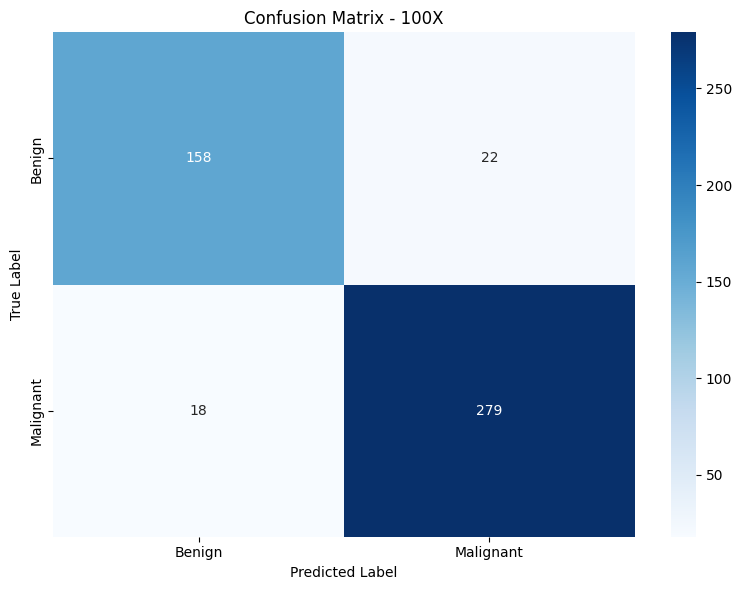


Starting experiment for 200X...

Training on 200X magnification

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   1: Train Loss: 1.7463, Val Loss: 0.6940, Val AUC: 0.7625


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch   2: Train Loss: 0.5767, Val Loss: 0.7091, Val AUC: 0.7821


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   3: Train Loss: 0.5356, Val Loss: 0.6171, Val AUC: 0.7941


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   4: Train Loss: 0.5381, Val Loss: 0.5687, Val AUC: 0.7888


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch   5: Train Loss: 0.5222, Val Loss: 0.5994, Val AUC: 0.7847


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch   6: Train Loss: 0.5241, Val Loss: 0.5728, Val AUC: 0.8074


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   7: Train Loss: 0.5215, Val Loss: 0.5686, Val AUC: 0.8026


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch   8: Train Loss: 0.5144, Val Loss: 0.5979, Val AUC: 0.8157


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   9: Train Loss: 0.5143, Val Loss: 0.5778, Val AUC: 0.8095


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  10: Train Loss: 0.5146, Val Loss: 0.5786, Val AUC: 0.8110


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch  11: Train Loss: 0.5296, Val Loss: 0.5779, Val AUC: 0.8076


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch  12: Train Loss: 0.5156, Val Loss: 0.5949, Val AUC: 0.7990


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch  13: Train Loss: 0.5082, Val Loss: 0.6194, Val AUC: 0.8021


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch  14: Train Loss: 0.4949, Val Loss: 0.6407, Val AUC: 0.8046


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch  15: Train Loss: 0.5035, Val Loss: 0.6352, Val AUC: 0.8188


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  16: Train Loss: 0.4778, Val Loss: 0.6519, Val AUC: 0.8269


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch  17: Train Loss: 0.4677, Val Loss: 0.6355, Val AUC: 0.8212


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch  18: Train Loss: 0.4788, Val Loss: 0.5926, Val AUC: 0.8183


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  19: Train Loss: 0.4619, Val Loss: 0.6164, Val AUC: 0.8137


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  20: Train Loss: 0.4673, Val Loss: 0.5747, Val AUC: 0.8134


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch  21: Train Loss: 0.4553, Val Loss: 0.6556, Val AUC: 0.8177


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch  22: Train Loss: 0.4457, Val Loss: 0.5724, Val AUC: 0.8145


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch  23: Train Loss: 0.4437, Val Loss: 0.5602, Val AUC: 0.8160


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  24: Train Loss: 0.4275, Val Loss: 0.5844, Val AUC: 0.8096


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch  25: Train Loss: 0.4270, Val Loss: 0.5633, Val AUC: 0.8138


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch  26: Train Loss: 0.4388, Val Loss: 0.5987, Val AUC: 0.8047
Early stopping at epoch 26

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch   1: Train Loss: 0.4786, Val Loss: 0.5708, Val AUC: 0.8132


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch   2: Train Loss: 0.4530, Val Loss: 0.6209, Val AUC: 0.8029


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch   3: Train Loss: 0.4248, Val Loss: 0.5798, Val AUC: 0.8587


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch   4: Train Loss: 0.3935, Val Loss: 0.5263, Val AUC: 0.8603


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch   5: Train Loss: 0.4060, Val Loss: 0.5071, Val AUC: 0.8750


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   6: Train Loss: 0.4084, Val Loss: 0.6348, Val AUC: 0.8281


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch   7: Train Loss: 0.3920, Val Loss: 0.5920, Val AUC: 0.8402


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch   8: Train Loss: 0.4037, Val Loss: 0.5460, Val AUC: 0.8420


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch   9: Train Loss: 0.3950, Val Loss: 0.5269, Val AUC: 0.8521


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  10: Train Loss: 0.3802, Val Loss: 0.5458, Val AUC: 0.8023


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  11: Train Loss: 0.3690, Val Loss: 0.5568, Val AUC: 0.8220


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  12: Train Loss: 0.3606, Val Loss: 0.5833, Val AUC: 0.8123


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  13: Train Loss: 0.3546, Val Loss: 0.5615, Val AUC: 0.8328


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  14: Train Loss: 0.3525, Val Loss: 0.5741, Val AUC: 0.7755


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  15: Train Loss: 0.3484, Val Loss: 0.5799, Val AUC: 0.8135
Early stopping at epoch 15


Testing: 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]



Best validation AUC: 0.8750
Test metrics:
  accuracy: 0.8758
  precision: 0.9225
  recall: 0.8718
  specificity: 0.8824
  f1: 0.8964
  auc_roc: 0.8917


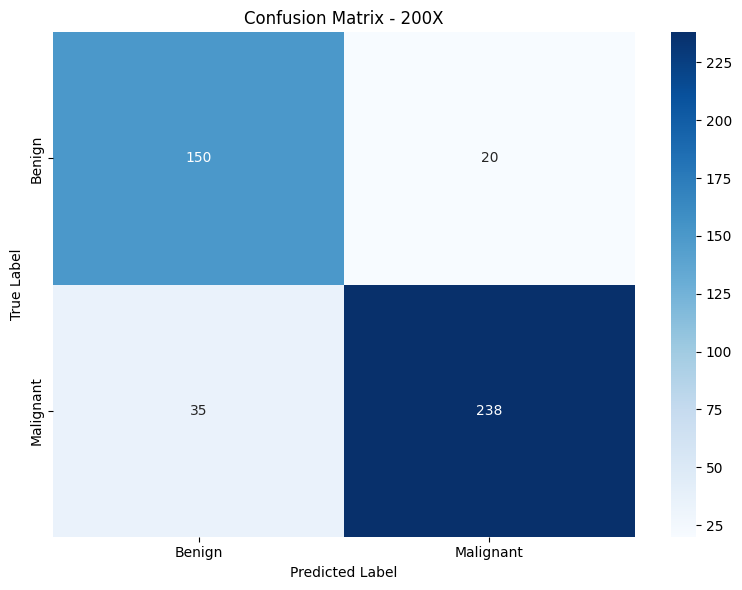


Starting experiment for 400X...

Training on 400X magnification

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   1: Train Loss: 1.9948, Val Loss: 0.7273, Val AUC: 0.8105


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch   2: Train Loss: 0.6155, Val Loss: 0.5918, Val AUC: 0.8486


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch   3: Train Loss: 0.6207, Val Loss: 0.8774, Val AUC: 0.8597


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch   4: Train Loss: 0.6031, Val Loss: 0.6785, Val AUC: 0.8631


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch   5: Train Loss: 0.5639, Val Loss: 0.8755, Val AUC: 0.8764


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   6: Train Loss: 0.5818, Val Loss: 0.8692, Val AUC: 0.8650


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   7: Train Loss: 0.5685, Val Loss: 0.7517, Val AUC: 0.8754


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Epoch   8: Train Loss: 0.5681, Val Loss: 0.6399, Val AUC: 0.8737


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Epoch   9: Train Loss: 0.5745, Val Loss: 0.7111, Val AUC: 0.8790


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch  10: Train Loss: 0.5670, Val Loss: 0.5422, Val AUC: 0.8727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  11: Train Loss: 0.5542, Val Loss: 0.5873, Val AUC: 0.8897


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch  12: Train Loss: 0.5598, Val Loss: 0.5956, Val AUC: 0.8820


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch  13: Train Loss: 0.5455, Val Loss: 0.6539, Val AUC: 0.8653


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  14: Train Loss: 0.5536, Val Loss: 0.5307, Val AUC: 0.8835


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch  15: Train Loss: 0.5387, Val Loss: 0.5743, Val AUC: 0.8900


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch  16: Train Loss: 0.5371, Val Loss: 0.5537, Val AUC: 0.8906


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch  17: Train Loss: 0.5397, Val Loss: 0.5655, Val AUC: 0.8968


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


Epoch  18: Train Loss: 0.5363, Val Loss: 0.6129, Val AUC: 0.8787


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch  19: Train Loss: 0.5434, Val Loss: 0.5633, Val AUC: 0.8670


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch  20: Train Loss: 0.5338, Val Loss: 0.7264, Val AUC: 0.8631


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch  21: Train Loss: 0.5275, Val Loss: 0.6100, Val AUC: 0.8767


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  22: Train Loss: 0.5176, Val Loss: 0.6144, Val AUC: 0.8736


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  23: Train Loss: 0.5258, Val Loss: 0.7300, Val AUC: 0.8691


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  24: Train Loss: 0.5294, Val Loss: 0.5682, Val AUC: 0.8651


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch  25: Train Loss: 0.4928, Val Loss: 0.6099, Val AUC: 0.8737


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch  26: Train Loss: 0.4978, Val Loss: 0.5920, Val AUC: 0.8728


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch  27: Train Loss: 0.5078, Val Loss: 0.6256, Val AUC: 0.8656
Early stopping at epoch 27

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch   1: Train Loss: 0.5322, Val Loss: 0.6366, Val AUC: 0.8785


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch   2: Train Loss: 0.5045, Val Loss: 0.6534, Val AUC: 0.8929


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   3: Train Loss: 0.4895, Val Loss: 0.5950, Val AUC: 0.8927


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch   4: Train Loss: 0.4550, Val Loss: 0.6623, Val AUC: 0.9028


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch   5: Train Loss: 0.4562, Val Loss: 0.6301, Val AUC: 0.8660


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch   6: Train Loss: 0.4227, Val Loss: 0.5928, Val AUC: 0.8697


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch   7: Train Loss: 0.4319, Val Loss: 0.5326, Val AUC: 0.8917


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Epoch   8: Train Loss: 0.4099, Val Loss: 0.6294, Val AUC: 0.8131


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


Epoch   9: Train Loss: 0.4195, Val Loss: 0.5711, Val AUC: 0.8206


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Epoch  10: Train Loss: 0.4127, Val Loss: 0.6895, Val AUC: 0.8426


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


Epoch  11: Train Loss: 0.3913, Val Loss: 0.6158, Val AUC: 0.8748


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Epoch  12: Train Loss: 0.3831, Val Loss: 0.5586, Val AUC: 0.8746


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch  13: Train Loss: 0.3759, Val Loss: 0.5743, Val AUC: 0.8718


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch  14: Train Loss: 0.3808, Val Loss: 0.6091, Val AUC: 0.8656
Early stopping at epoch 14


Testing: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]



Best validation AUC: 0.9028
Test metrics:
  accuracy: 0.8655
  precision: 0.9018
  recall: 0.8670
  specificity: 0.8634
  f1: 0.8840
  auc_roc: 0.8707


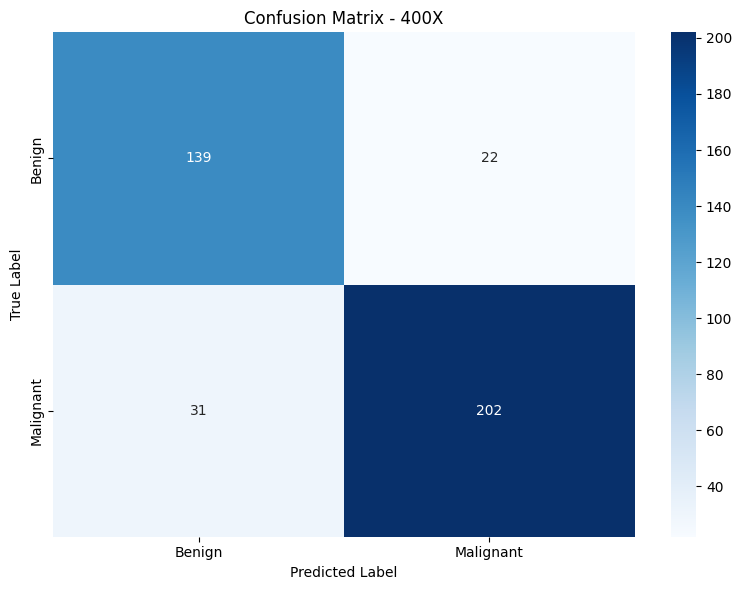


Starting experiment for All...

Training on All magnification

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Epoch   1: Train Loss: 1.1307, Val Loss: 0.6381, Val AUC: 0.7681


Validation: 100%|██████████| 48/48 [00:20<00:00,  2.29it/s]


Epoch   2: Train Loss: 0.5798, Val Loss: 0.6758, Val AUC: 0.7920


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Epoch   3: Train Loss: 0.5760, Val Loss: 0.6564, Val AUC: 0.7961


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Epoch   4: Train Loss: 0.5715, Val Loss: 0.5883, Val AUC: 0.8123


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch   5: Train Loss: 0.5679, Val Loss: 0.5667, Val AUC: 0.7925


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch   6: Train Loss: 0.5573, Val Loss: 0.5690, Val AUC: 0.8086


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch   7: Train Loss: 0.5545, Val Loss: 0.6332, Val AUC: 0.8074


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch   8: Train Loss: 0.5442, Val Loss: 0.5970, Val AUC: 0.8072


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch   9: Train Loss: 0.5532, Val Loss: 0.6033, Val AUC: 0.8032


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch  10: Train Loss: 0.5487, Val Loss: 0.5547, Val AUC: 0.7970


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Epoch  11: Train Loss: 0.5218, Val Loss: 0.6295, Val AUC: 0.8006


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch  12: Train Loss: 0.5161, Val Loss: 0.6177, Val AUC: 0.8095


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch  13: Train Loss: 0.5157, Val Loss: 0.6153, Val AUC: 0.8158


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Epoch  14: Train Loss: 0.5138, Val Loss: 0.6026, Val AUC: 0.8287


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch  15: Train Loss: 0.5165, Val Loss: 0.5895, Val AUC: 0.8252


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch  16: Train Loss: 0.5062, Val Loss: 0.5866, Val AUC: 0.8091


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch  17: Train Loss: 0.5082, Val Loss: 0.6031, Val AUC: 0.8225


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Epoch  18: Train Loss: 0.4962, Val Loss: 0.5914, Val AUC: 0.8165


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch  19: Train Loss: 0.5043, Val Loss: 0.6101, Val AUC: 0.8045


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


Epoch  20: Train Loss: 0.5071, Val Loss: 0.5966, Val AUC: 0.8150


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Epoch  21: Train Loss: 0.4979, Val Loss: 0.6036, Val AUC: 0.8090


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch  22: Train Loss: 0.4868, Val Loss: 0.6076, Val AUC: 0.8152


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


Epoch  23: Train Loss: 0.4880, Val Loss: 0.6095, Val AUC: 0.8076


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Epoch  24: Train Loss: 0.4882, Val Loss: 0.5925, Val AUC: 0.8050
Early stopping at epoch 24

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Epoch   1: Train Loss: 0.5328, Val Loss: 0.5825, Val AUC: 0.8526


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch   2: Train Loss: 0.4716, Val Loss: 0.5405, Val AUC: 0.8488


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch   3: Train Loss: 0.4428, Val Loss: 0.5897, Val AUC: 0.8424


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch   4: Train Loss: 0.4395, Val Loss: 0.5229, Val AUC: 0.8764


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


Epoch   5: Train Loss: 0.4199, Val Loss: 0.5472, Val AUC: 0.8785


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch   6: Train Loss: 0.4136, Val Loss: 0.5694, Val AUC: 0.8655


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch   7: Train Loss: 0.4049, Val Loss: 0.5811, Val AUC: 0.8480


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


Epoch   8: Train Loss: 0.4054, Val Loss: 0.5487, Val AUC: 0.8530


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch   9: Train Loss: 0.3931, Val Loss: 0.5630, Val AUC: 0.8638


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch  10: Train Loss: 0.3851, Val Loss: 0.5396, Val AUC: 0.8814


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


Epoch  11: Train Loss: 0.3873, Val Loss: 0.4973, Val AUC: 0.8682


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch  12: Train Loss: 0.3904, Val Loss: 0.5164, Val AUC: 0.8646


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch  13: Train Loss: 0.3811, Val Loss: 0.4782, Val AUC: 0.8842


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


Epoch  14: Train Loss: 0.3797, Val Loss: 0.6340, Val AUC: 0.8363


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch  15: Train Loss: 0.3702, Val Loss: 0.5454, Val AUC: 0.8402


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch  16: Train Loss: 0.3768, Val Loss: 0.6115, Val AUC: 0.8763


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Epoch  17: Train Loss: 0.3719, Val Loss: 0.5029, Val AUC: 0.8805


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch  18: Train Loss: 0.3751, Val Loss: 0.4900, Val AUC: 0.8564


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Epoch  19: Train Loss: 0.3731, Val Loss: 0.5140, Val AUC: 0.8543


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Epoch  20: Train Loss: 0.3597, Val Loss: 0.5356, Val AUC: 0.8628


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch  21: Train Loss: 0.3568, Val Loss: 0.5166, Val AUC: 0.8492


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch  22: Train Loss: 0.3555, Val Loss: 0.4992, Val AUC: 0.8600


Validation: 100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Epoch  23: Train Loss: 0.3481, Val Loss: 0.5067, Val AUC: 0.8807
Early stopping at epoch 23


Testing: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]



Best validation AUC: 0.8842
Test metrics:
  accuracy: 0.8803
  precision: 0.9209
  recall: 0.8776
  specificity: 0.8846
  f1: 0.8987
  auc_roc: 0.9018


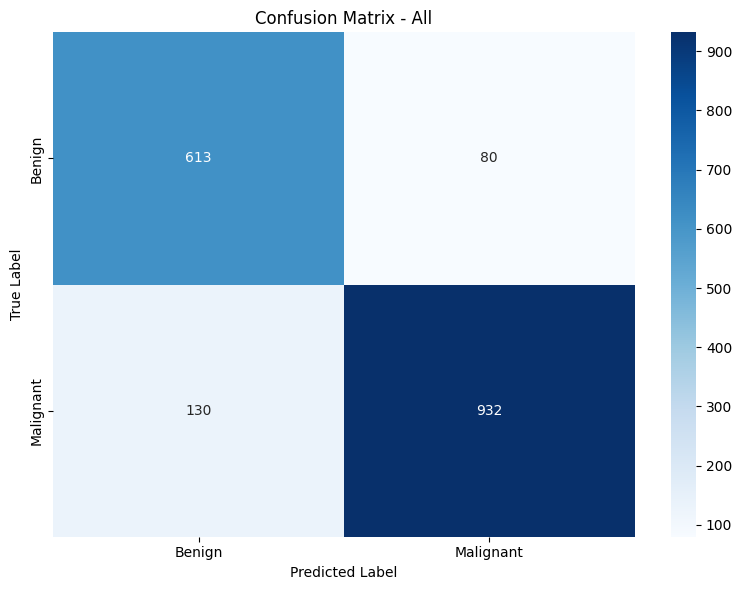


FINAL RESULTS TABLE
Magnification  Accuracy  Precision  Recall  Specificity     F1  AUC-ROC
          40X    0.8526     0.9254  0.8147       0.9066 0.8665   0.8737
         100X    0.9161     0.9269  0.9394       0.8778 0.9331   0.9451
         200X    0.8758     0.9225  0.8718       0.8824 0.8964   0.8917
         400X    0.8655     0.9018  0.8670       0.8634 0.8840   0.8707
          All    0.8803     0.9209  0.8776       0.8846 0.8987   0.9018

Results saved to 'breakhis_results.csv'

EXPERIMENT SUMMARY
Average Accuracy: 0.8781
Average AUC-ROC: 0.8966
Best performing magnification: 100X


In [25]:

if __name__ == "__main__":
    results = main()